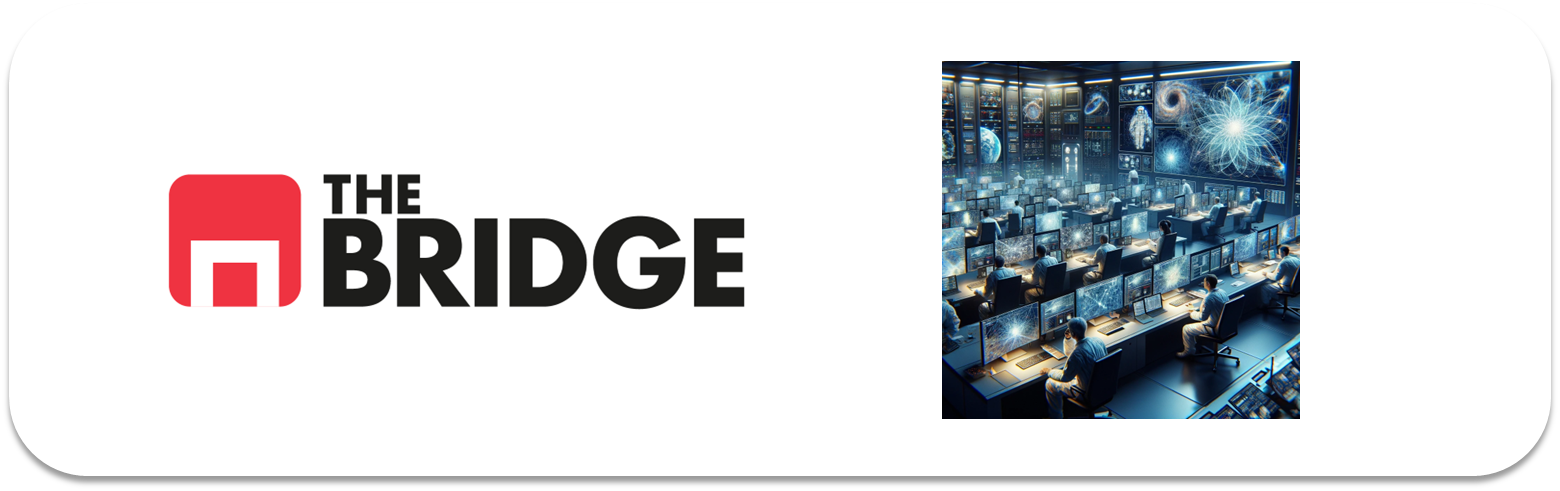

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



### 1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

In [92]:
ROOT_PATH = './data/'

In [93]:
def read_data(directorio, reshape_dim = (32,32)):
    
    X_train = [] 
    X_test = []
    y_train = []
    y_test = []
    
    for folder in os.listdir(directorio):
        
        print("Leer carpeta:", folder)
                
        if os.path.isdir('/'.join([directorio, folder])):
            
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim)

                if folder == "github_test":

                    X_test.append(image)
                    y_test.append(file.split(".")[0])
                                 
                else:

                    X_train.append(image)
                    y_train.append(file.split(".")[0])

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [94]:
X_train, y_train, X_test, y_test = read_data(ROOT_PATH)

Leer carpeta: github_test


Leer carpeta: github_train_0
Leer carpeta: github_train_1
Leer carpeta: github_train_2
Leer carpeta: github_train_3


In [95]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (4000, 32, 32, 3)
Y train shape:  (4000,)


In [96]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (1000, 32, 32, 3)
Y train shape:  (1000,)


## Visualizar imágenes

In [97]:
def show_images_batch(pets, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

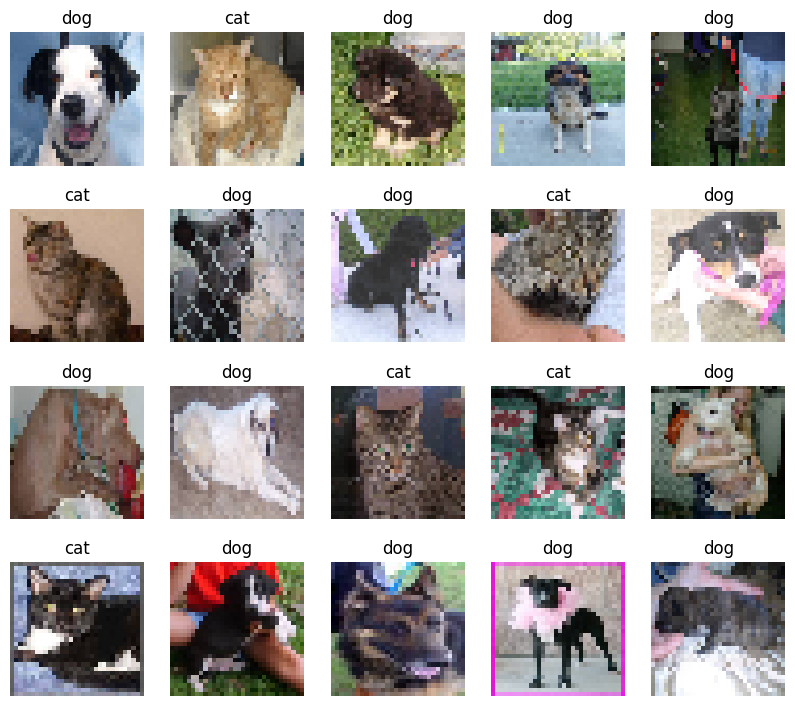

In [98]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

### 2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

### mini eda

In [99]:
targets = pd.Series(y_train)
targets.value_counts(True)

cat    0.5
dog    0.5
Name: proportion, dtype: float64

In [100]:
X_train = X_train/255
X_test = X_test/255

In [101]:
# Primero definimos las capas de la red, en este caso partimos de 30 filtros de 3x3, seguido de una capa de pooling de 2x2,
# El input shape es el tamaño de las imágenes de entrada, en nuestro caso 32x32x3. 
# El tamaño del kernel es pequeño pero suele ser de este tipo y más con resoluciones tan bajas, el número de filtros está escogido de aquella manera,
# juega con el número de filtros.

capas = [keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 20, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 2 neuronas, una por cada clase
         keras.layers.Dense(2, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

Miro el  tamaño 

In [102]:

X_train.size

12288000

Usaré Adam

In [103]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [104]:
#miro el resumen del modelo

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 20)        5780      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 20)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 150)              

In [105]:
#convierto a ordinal
map = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
map

y_train_num = np.array([map[y] for y in y_train])
y_test_num = np.array([map[y] for y in y_test])

In [106]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

## 3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

In [107]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)])

Epoch 1/100
 76/100 [=====================>........] - ETA: 0s - loss: 0.6868 - accuracy: 0.5354

100/100 [==============================] - 2s 11ms/step - loss: 0.6740 - accuracy: 0.5616 - val_loss: 0.6438 - val_accuracy: 0.6288
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6192 - accuracy: 0.6625 - val_loss: 0.6566 - val_accuracy: 0.6062
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.5802 - accuracy: 0.6909 - val_loss: 0.6021 - val_accuracy: 0.6762
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 0.5405 - accuracy: 0.7241 - val_loss: 0.5786 - val_accuracy: 0.6975
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.4864 - accuracy: 0.7600 - val_loss: 0.5548 - val_accuracy: 0.7312
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 0.4475 - accuracy: 0.7847 - val_loss: 0.5974 - val_accuracy: 0.7038
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.4022 - accuracy: 0.8156 - val_loss: 0.6083 - val_accuracy: 0.7075
Epoch 8/10

Visualizar el entrenamiento

In [108]:
#muestro el historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.674050,0.561562,0.643829,0.62875
1,0.619237,0.662500,0.656600,0.60625
2,0.580237,0.690938,0.602110,0.67625
3,0.540491,0.724063,0.578555,0.69750
4,0.486407,0.760000,0.554751,0.73125
5,0.447510,0.784688,0.597412,0.70375
6,0.402195,0.815625,0.608261,0.70750
7,0.348546,0.850625,0.652356,0.71250
8,0.303476,0.871875,0.782191,0.65500
9,0.245590,0.893125,0.823674,0.70250


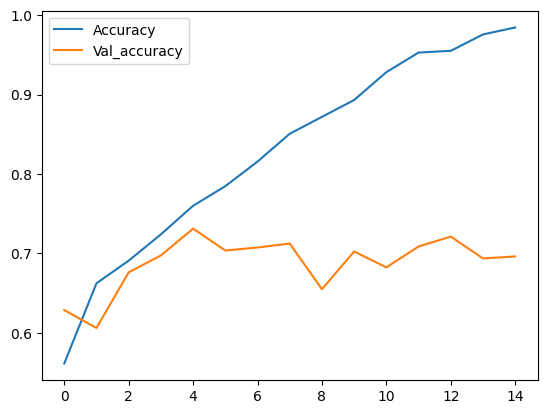

In [109]:
# Representamos el objeto history

plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

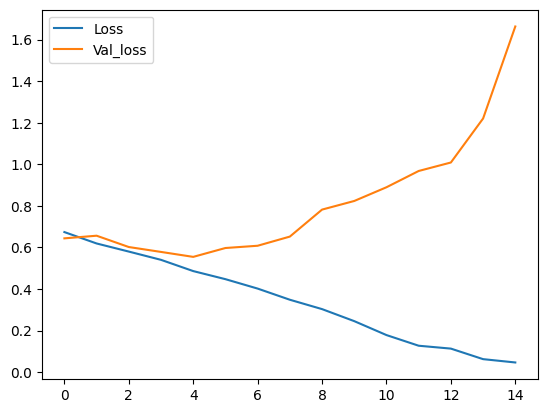

In [110]:
#miramos las pérdidas
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

### 4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

In [111]:
model.evaluate(X_test, y_test_num)
#acuracy del 50%

32/32 [==============================] - 0s 4ms/step - loss: 0.5362 - accuracy: 0.7320


[0.5362349152565002, 0.7319999933242798]

In [112]:
#classification report
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

32/32 [==============================] - 0s 3ms/step


In [113]:

inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

         cat       0.72      0.77      0.74       500
         dog       0.75      0.69      0.72       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



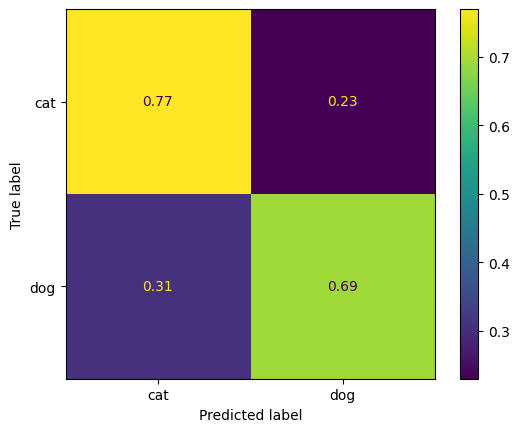

In [114]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

#### Tube que subir a 20 filtros, porque me daba un accuracy de 50 y precisión de 50%

### 5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


In [115]:
confianza = [prediction.max() for prediction in model.predict(X_test)]

32/32 [==============================] - 0s 2ms/step


In [116]:
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

#### selección de 10% imágenes mal clasificadas

In [118]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores = errores.iloc[0:int(0.1*len(errores))]
errores

,True,Predicted,Confianza
337,cat,dog,0.992847
680,dog,cat,0.989441
888,dog,cat,0.987782
851,dog,cat,0.956342
662,dog,cat,0.940296
359,cat,dog,0.929920
175,cat,dog,0.928174
107,cat,dog,0.921541
537,dog,cat,0.905423
893,dog,cat,0.904089


In [119]:
for true_label, predicted_label in errores.iloc[0:10,0:2].values:
    print(true_label, predicted_label)

cat dog
dog cat
dog cat
dog cat
dog cat
cat dog
cat dog
cat dog
dog cat
dog cat


IndexError: list index out of range

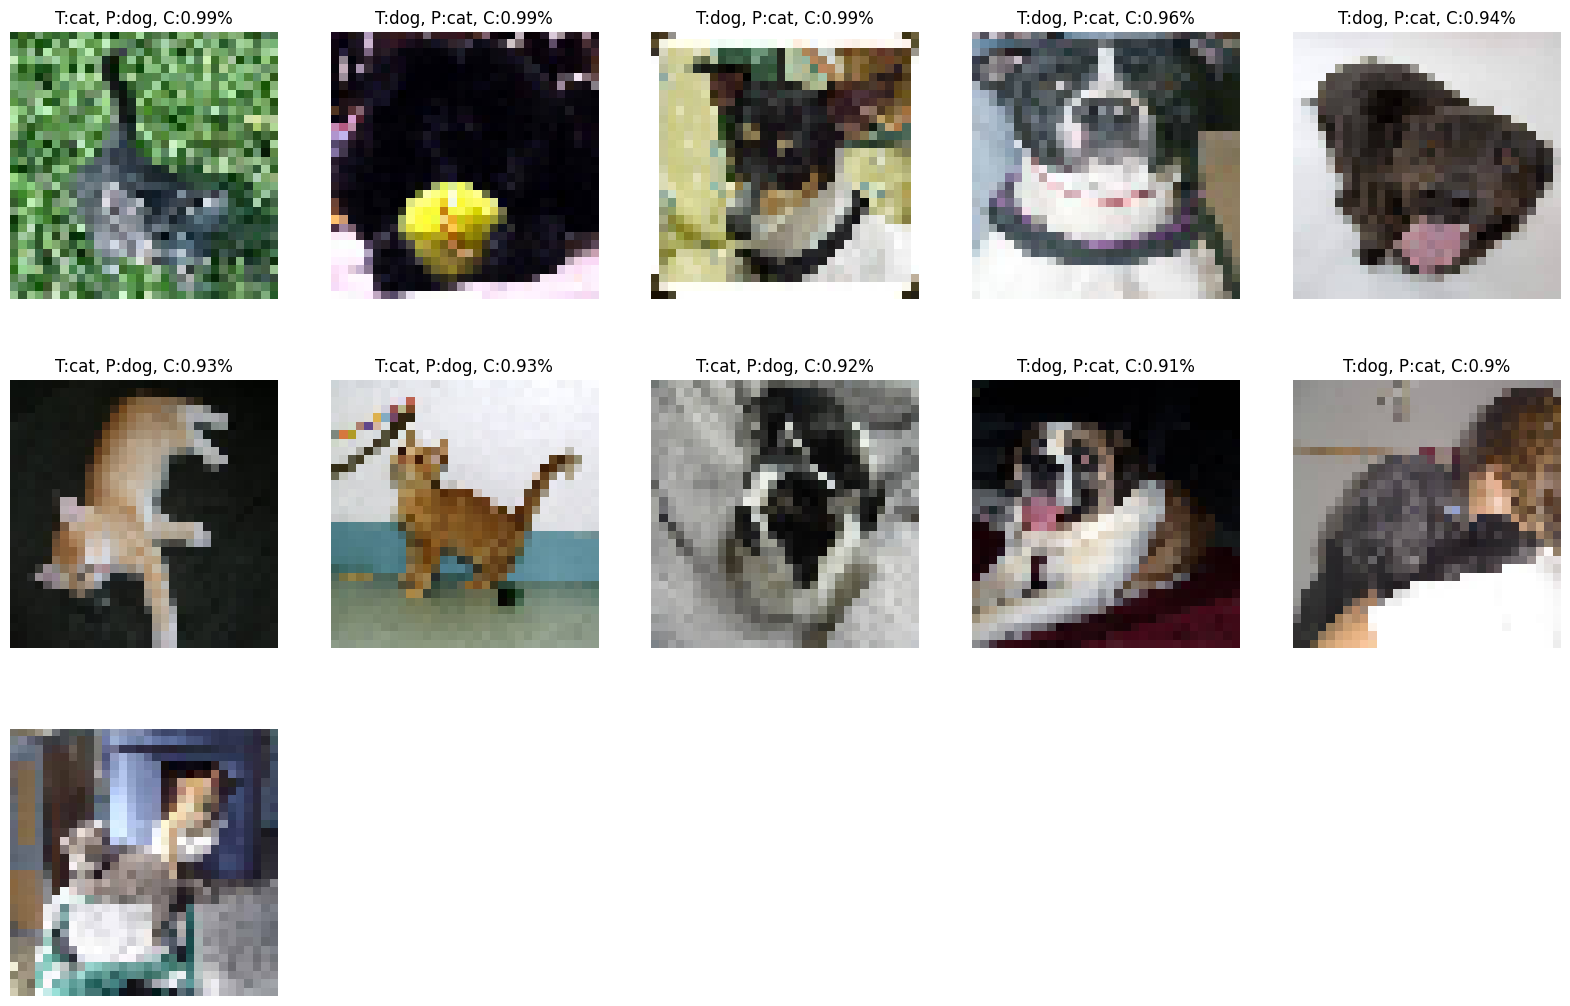

In [126]:
show_images_batch(X_test[errores.iloc[0:].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)